1. Changed how amenities is extracted - small change
2. Removed more features - small change
3. increased train size - improvement in test r2 socre
4. Removed one-hot from property_type, city, and room_type since LightGBM inherently supports categorical features
5. Removed more unnecessary features
6. Removed features that were having a negative impact
7. Improved parameters - Reduced overfitting drastically

In [38]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from scipy import stats
from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from numpy import logspace
import lightgbm as lgb
from sklearn import ensemble
import warnings
warnings.filterwarnings('ignore')

In [39]:
# Loading airbnb data of 8 cities
montreal = pd.read_csv('Dataset/Airbnb/Montreal.csv')
newbrunswick = pd.read_csv('Dataset/Airbnb/NewBrunswick.csv')
ottawa = pd.read_csv('Dataset/Airbnb/Ottawa.csv')
quebeccity = pd.read_csv('Dataset/Airbnb/QuebecCity.csv')
toronto = pd.read_csv('Dataset/Airbnb/Toronto.csv')
vancouver = pd.read_csv('Dataset/Airbnb/Vancouver.csv')
victoria = pd.read_csv('Dataset/Airbnb/Victoria.csv')
winnipeg = pd.read_csv('Dataset/Airbnb/Winnipeg.csv')

# Adding a City column to each dataframes
montreal['city'] = 'Montreal'
newbrunswick['city'] = 'New Brunswick'
ottawa['city'] = 'Ottawa'
quebeccity['city'] = 'Quebec City'
toronto['city'] = 'Toronto'
vancouver['city'] = 'Vancouver'
victoria['city'] = 'Victoria'
winnipeg['city'] = 'Winnipeg'

# Merging data from different cities to a single dataframe
airbnb_df = pd.concat([montreal, newbrunswick, ottawa, quebeccity, toronto, vancouver, victoria, winnipeg], ignore_index=True)

In [40]:
# Loading the review sentiment scores
reviews_df = pd.read_csv('Dataset/Sentiment/listing_sentiment_scores.csv')

airbnb_df = pd.merge(airbnb_df, reviews_df, left_on='id', right_on='listing_id', how='left')

In [41]:
airbnb_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,listing_id,sentiment_score
0,29059,https://www.airbnb.com/rooms/29059,20240323015116,2024-03-23,city scrape,Lovely studio Quartier Latin,CITQ 267153<br />Lovely studio with 1 closed r...,NaN,https://a0.muscache.com/pictures/736399/fa6c31...,125031,...,"267153, expires: 2024-03-31",f,2,2,0,0,2.69,Montreal,29059.0,0.70
1,29061,https://www.airbnb.com/rooms/29061,20240323015116,2024-03-23,city scrape,Maison historique - Quartier Latin,Lovely historic house with plenty of period ch...,NaN,https://a0.muscache.com/pictures/9e59d417-4b6a...,125031,...,"267153, expires: 2024-03-31",f,2,2,0,0,0.88,Montreal,29061.0,0.70
2,36301,https://www.airbnb.com/rooms/36301,20240323015116,2024-03-23,city scrape,Romantic & peaceful Plateau loft,"Enjoy the best of Montreal in this romantic, ...",The neighborhood is very lively while the stre...,https://a0.muscache.com/pictures/26c20544-475f...,381468,...,NaN,f,3,3,0,0,0.47,Montreal,36301.0,0.78
3,38118,https://www.airbnb.com/rooms/38118,20240323015116,2024-03-23,city scrape,Beautiful room with a balcony in front of a parc,Nearest metro Papineau.,NaN,https://a0.muscache.com/pictures/213997/763ec1...,163569,...,NaN,f,1,0,1,0,0.10,Montreal,38118.0,0.73
4,50479,https://www.airbnb.com/rooms/50479,20240323015116,2024-03-23,city scrape,L'Arcade Douce,The appartement is sunny and ideally situated ...,Our area is full of life (but our street is qu...,https://a0.muscache.com/pictures/miso/Hosting-...,231694,...,"271530, expires: 2024-04-30",t,2,1,1,0,1.60,Montreal,50479.0,0.65


Initial Feature Elimination

In [42]:
feature_elimination_list = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'host_url', 'host_thumbnail_url', 'calendar_updated', 'calendar_last_scraped', 'host_name', 'listing_id', 'host_id', 'neighbourhood_group_cleansed', 'host_neighbourhood', 'host_location', 'neighbourhood', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'review_scores_accuracy', 'bathrooms_text', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'host_about', 'neighborhood_overview', 'host_has_profile_pic', 'picture_url', 'host_picture_url']

airbnb_df = airbnb_df.drop(feature_elimination_list, axis=1)

Renaming columns

In [43]:
# Mapping new column names
column_mappings = {
    'name': 'title',
    'first_review': 'first_review_date',
    'last_review': 'last_review_date',
    'review_scores_value': 'review_scores_value_for_money',
    'calculated_host_listings_count': 'host_listings_count',
    'neighbourhood_cleansed': 'neighbourhood',
    'sentiment_score': 'review_sentiment_score'
}

# Renaming columns
airbnb_df.rename(columns=column_mappings, inplace=True)

Price to integer

In [44]:
# Removing "$" from price and converting to float
airbnb_df['price'] = airbnb_df['price'].str.replace('[$,]', '', regex=True).astype(float)

Train-test split

In [45]:
data_train, data_test = train_test_split(airbnb_df, test_size=0.01, random_state=42)

Preprocessing

In [46]:
# Converting values in price column to its natural logarithm
data_train['price'] = np.log(data_train['price'])

In [47]:
# Fill null value with unlicensed
data_train['license'].fillna('Unlicensed', inplace=True)

In [48]:
# Drop rows with empty price
data_train = data_train.dropna(subset=['price'])

In [49]:
# Fill null values with 0 for specified columns where 'number_of_reviews' equals 0
# columns_to_fill = [
#     'review_scores_value_for_money',
#     'review_scores_location',
#     'review_scores_checkin',
#     'review_scores_communication',
#     'review_scores_cleanliness',
#     'review_scores_rating'
# ]
# 
# for column in columns_to_fill:
#     data_train.loc[data_train['number_of_reviews'] == 0, column] = 0

In [50]:
data_train = data_train.dropna(subset=['number_of_reviews'])
data_train = data_train.dropna(subset=['review_scores_rating'])
data_train = data_train.dropna(subset=['review_sentiment_score'])

In [51]:
# data_train['review_sentiment_score'].fillna(0, inplace=True)

In [52]:
# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

# Fill null values with today's date where 'number_of_reviews' equals 0
data_train.loc[data_train['number_of_reviews'] == 0, 'first_review_date'] = data_train.loc[data_train['number_of_reviews'] == 0, 'first_review_date'].fillna(today_date)
data_train.loc[data_train['number_of_reviews'] == 0, 'last_review_date'] = data_train.loc[data_train['number_of_reviews'] == 0, 'last_review_date'].fillna(today_date)

In [53]:
data_train['host_is_superhost'] = data_train['host_is_superhost'].fillna('f')
data_train['has_availability'] = data_train['has_availability'].fillna('f')

In [54]:
data_train['host_response_time'] = data_train['host_response_time'].fillna(data_train['host_response_time'].mode()[0])

In [55]:
# Remove % sign and convert to numeric for the following columns
data_train['host_response_rate'] = pd.to_numeric(data_train['host_response_rate'].str.replace('%', ''))
data_train['host_acceptance_rate'] = pd.to_numeric(data_train['host_acceptance_rate'].str.replace('%', ''))

# Creating a list of required columns
numeric_columns = [
    'host_response_rate',
    'host_acceptance_rate',
    'bedrooms', 'beds', 
    'review_scores_value_for_money', 
    'review_scores_location', 
    'review_scores_checkin', 
    'review_scores_communication', 
    'review_scores_cleanliness', 
    'bathrooms'
]

# Fill null values in specified columns with median values
for column in numeric_columns:
    median_value = data_train[column].median()
    data_train[column].fillna(median_value, inplace=True)

Feature Engineering

In [56]:
current_date = datetime.now()

# Converting date columns
data_train['host_since'] = pd.to_datetime(data_train['host_since'])
data_train['first_review_date'] = pd.to_datetime(data_train['first_review_date'])
data_train['last_review_date'] = pd.to_datetime(data_train['last_review_date'])

# Calculating values and storing in a new column
data_train['host_since_days'] = (current_date - data_train['host_since']).dt.days
data_train['first_review_days'] = (current_date - data_train['first_review_date']).dt.days
data_train['last_review_days'] = (current_date - data_train['last_review_date']).dt.days

# Dropping date columns
data_train.drop(columns=['host_since', 'first_review_date', 'last_review_date'], inplace=True)

In [57]:
# Define downtown coordinates for each city
downtown_coords = {
    'Montreal': (45.5017, -73.5673),
    'New Brunswick': (45.9636, -66.6372),  # Fredericton
    'Ottawa': (45.4215, -75.6972),
    'Quebec City': (46.8139, -71.2080),
    'Toronto': (43.6532, -79.3832),
    'Vancouver': (49.2827, -123.1207),
    'Victoria': (48.4284, -123.3656),
    'Winnipeg': (49.8951, -97.1384)
}

In [58]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

In [59]:
# Calculate distance to downtown using broadcasting
for city, (lat, lon) in downtown_coords.items():
    mask = data_train['city'] == city
    data_train.loc[mask, 'distance_to_downtown'] = haversine_distance(
        data_train.loc[mask, 'latitude'].values, 
        data_train.loc[mask, 'longitude'].values, 
        lat, 
        lon
    )

In [60]:
# Load attraction data
attractions_df = pd.read_csv('Dataset/Locations/canadian_tourist_attractions.csv')
attractions_df['city'] = attractions_df['city'].str.title().str.replace('_', ' ')
attractions_df.head()

,city,name,latitude,longitude,type
0,Montreal,Musée des Beaux-Arts de Montréal,45.498697,-73.579385,museum
1,Montreal,Belvédère Léo-Ayotte,45.523223,-73.568744,viewpoint
2,Montreal,Musée des ondes Emile Berliner,45.477550,-73.592403,museum
3,Montreal,Orbite,45.523473,-73.536689,attraction
4,Montreal,Spirale,45.525468,-73.534699,attraction


In [61]:
# Count attractions within 10km using broadcasting
def count_attractions_within_radius(airbnb_lat, airbnb_lon, attractions, radius_km=10):
    distances = haversine_distance(airbnb_lat, airbnb_lon, attractions['latitude'].values, attractions['longitude'].values)
    return np.sum(distances <= radius_km)

# Calculate attractions within 10km for each Airbnb listing
attraction_counts = []
for city in data_train['city'].unique():
    attractions_city = attractions_df[attractions_df['city'] == city]
    if not attractions_city.empty:
        attraction_counts.extend(data_train[data_train['city'] == city].apply(
            lambda row: count_attractions_within_radius(row['latitude'], row['longitude'], attractions_city),
            axis=1
        ))
    else:
        attraction_counts.extend([0] * len(data_train[data_train['city'] == city]))

data_train['nearby_attractions'] = attraction_counts

Data Encoding

In [62]:
for boolean_column in ['host_is_superhost', 'host_identity_verified', 'has_availability', 'instant_bookable']:
    data_train[boolean_column] = data_train[boolean_column].map(lambda s: False if s == "f" else True)

In [63]:
# Changing data
data_train['license'] = data_train['license'].map(lambda s: False if s == "Unlicensed" else True)

In [64]:
# Define the order of categories
categories = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']

# Initialize OrdinalEncoder with the defined categories
ordinal_encoder = OrdinalEncoder(categories=[categories])

# Fit and transform the 'host_response_time' column
data_train['host_response_time_encoded'] = ordinal_encoder.fit_transform(data_train[['host_response_time']])

# Dropping the categorical column
data_train.drop(columns=['host_response_time'], inplace=True)

In [65]:
# data_train = pd.get_dummies(data_train, columns=['property_type'], prefix='property')
# data_train = pd.get_dummies(data_train, columns=['city'], prefix='city')
# data_train = pd.get_dummies(data_train, columns=['room_type'], prefix='room_type')

In [66]:
# Function to safely evaluate strings
def safe_eval(x):
    if isinstance(x, str):
        return eval(x)
    return x

# Extract unique items from the list in the column
unique_items = set(item for sublist in data_train['host_verifications'].apply(safe_eval) for item in sublist)

# Apply one hot encoding to the unique_items and create a new column for each item
for item in unique_items:
    column_name = item + "_verification"
    data_train[column_name] = data_train['host_verifications'].apply(lambda x: True if item in x else False)

# Drop the original amenities column
data_train.drop('host_verifications', axis=1, inplace=True)

Feature Extraction

In [67]:
# Flatten the lists and extract unique items
unique_items = set(item for sublist in data_train['amenities'].apply(safe_eval) for item in sublist if item)

In [68]:
#Define keywords and corresponding regex patterns
keywords_patterns = {
    'tv': r'\b(TV|HDTV|Roku|chromecast)\b',
    'netflix': r'\b(Netflix|Amazon|hulu|disney+)\b',
    'pool': r'\b(Pool|Swimming pool)\b',
    'oven': r'\b(Oven|microwave)\b',
    'stove': r'\b(Stove|stove)\b',
    'wifi': r'\b(Wifi)\b',
    'toiletries': r'\b(Toiletries|Shampoo|Brush|Conditioner|soap|wash|shower gel)\b',
    'parking': r'\b(parking|carport)\b',
    'sound_system': r'\b(SoundSystem|Sound System|speakers|speaker|piano|record player)\b',
    'coffee_maker': r'\b(coffee|coffee-maker|coffeemaker|espresso)\b',
    'grill': r'\b(Grill|BBQ)\b',
    'workspace': r'\b(Workspace|Workspaces)\b',
    'closet': r'\b(Closet|storage|wardrobe|dresser)\b',
    'gym': r'\b(Exercise|yoga|elliptical|bike|bikes|gym)\b',
    'refrigerator': r'\b(Refrigerator|refrigerator|freezer|ice machine|fridge)\b',
    'housekeeping': r'\b(Housekeeping|Housekeeping)\b',
    'backyard': r'\b(backyard|patio|balcony)\b',
    'safety': r'\b(Safety|Safety|lock|pin|alarm|keypad)\b',
    'spa': r'\b(Sauna|sauna|jacuzzi|tub|spa|steam room|sun loungers)\b',
    'view': r'\b(lake|skyline|view|courtyard|resort|waterfront)\b',
    'laundry': r'\b(Laundry|laundry|laundromat)\b',
    'games': r'\b(Game console|gaming console|gaming consoles|ps2|ps3|ps4|ps5|xbox|nintendo|games|ping pong)\b',
    'first_aid': r'\b(first aid)\b',
    'smoke_alarm': r'\b(smoke alarm|fire extinguisher|alarm)\b',
    'private_entrance': r'\b(private entrance)\b',
    'AC': r'\b(heating|conditioning|AC)\b',
    'bedding': r'\b(pillows|pillow|blanket|blankets|bed linens)\b',
    'baby_ameneties': r'\b(crib|baby|high chair|changing table|playroom|playground)\b',
    'utensils': r'\b(utensils|cooking|dishes|silverware|glasses)\b',
    'kitchen': r'\b(kitchen|dining|rice maker|blender|kitchenette)\b',
    'bathtub': r'\b(bathtub)\b',
    'iron': r'\b(iron|ironing board)\b',
    'self_checking': r'\b(Self check-in|check-in|self_checking|self checkin|self checking)\b',
    'hair_dryer': r'\b(hair dryer)\b',
    'security_camera': r'\b(security|camera|cameras)\b',
    'toaster': r'\b(toaster|bread maker)\b',
    'pets_allowed' : r'\b(pets allowed)\b',
    'bookshelf': r'\b(bookshelf|books|reading)\b',
    'cleaning products': r'\b(cleaning products)\b',
    'fire pit': r'\b(fire pit|fire place|firepit|fireplace)\b',
    'garage': r'\b(garage)\b',
    'beach': r'\b(beach)\b',
    'host_there': r'\b(host greets you|property manager)\b',
    'bar': r'\b(bar)\b',
    'sports': r'\b(kayak|golf|ski|ski-in/ski-out|lasertag|laser tag|batting cage|wall climbing|climbing wall|bowling|hockey rink|skate ramp)\b',
    'ev_charger': r'\b(ev charger)\b',
    'movie_theater': r'\b(movie theater|media room|theme room)\b',
}

# Function to rename items based on regex patterns
def rename_item(amenity, patterns):
    for key, pattern in patterns.items():
        if re.search(pattern, amenity, flags=re.IGNORECASE):
            return key
    return None

# Function to rename items in the amenities list
def rename_amenities_list(amenities_list, patterns):
    return [rename_item(amenity, patterns) for amenity in amenities_list if rename_item(amenity, patterns) is not None]

# Filter out any empty strings from unique_amenities
filtered_unique_amenities = [amenity for amenity in unique_items if amenity.strip()]

# Apply the function to rename items in the filtered 'unique_amenities' list using list comprehension
updated_amenities = [rename_item(amenity, keywords_patterns) for amenity in filtered_unique_amenities]

# Remove items that did not match any keyword pattern
updated_amenities = [amenity for amenity in updated_amenities if amenity is not None]

# Extract unique items from the list in the column
unique_updated_amenities = list(set(updated_amenities))

# Print the total number of unique items
print("Total number of unique updated amenities:", len(unique_updated_amenities))
print(unique_updated_amenities)

Total number of unique updated amenities: 46
['cleaning products', 'AC', 'closet', 'bathtub', 'first_aid', 'workspace', 'grill', 'private_entrance', 'hair_dryer', 'pool', 'toaster', 'garage', 'ev_charger', 'self_checking', 'sound_system', 'pets_allowed', 'tv', 'utensils', 'fire pit', 'host_there', 'backyard', 'games', 'refrigerator', 'wifi', 'kitchen', 'parking', 'baby_ameneties', 'housekeeping', 'gym', 'beach', 'stove', 'spa', 'laundry', 'iron', 'netflix', 'toiletries', 'security_camera', 'movie_theater', 'bedding', 'coffee_maker', 'view', 'sports', 'safety', 'bookshelf', 'oven', 'smoke_alarm']


In [69]:
# Correctly rename items in the 'amenities' column
data_train['renamed_amenities'] = data_train['amenities'].apply(lambda x: rename_amenities_list(safe_eval(x), keywords_patterns) if isinstance(x, str) else [])

In [70]:
# Apply one hot encoding to the unique_items and create a new column for each item
for item in unique_updated_amenities:
    column_name = item + "_amenity"
    data_train[column_name] = data_train['renamed_amenities'].apply(lambda x: item in x)

# Drop the original amenities and renamed_amenities columns
data_train.drop(['amenities', 'renamed_amenities'], axis=1, inplace=True)

In [71]:
# Need to download once for sentiment analysis
nltk.download('vader_lexicon')

#creating an object of sentiment intensity analyzer
sia= SentimentIntensityAnalyzer()

# creating new columns using polarity scores function
data_train['title_scores'] = data_train['title'].apply(lambda title: sia.polarity_scores(str(title)))
data_train['title_sentiment']=data_train['title_scores'].apply(lambda score_dict:score_dict['compound'])
data_train.drop(['title', 'title_scores'], axis=1, inplace=True)


# creating new columns using polarity scores function
data_train['description_scores']=data_train['description'].apply(lambda description: sia.polarity_scores(str(description)))
data_train['description_sentiment']=data_train['description_scores'].apply(lambda score_dict:score_dict['compound'])
data_train.drop(['description', 'description_scores'], axis=1, inplace=True)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/prashansathapa/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Feature Selection

In [72]:
train_features = data_train.drop(['id', 'neighbourhood'], axis=1)

Replicating changes to test data

In [73]:
# Converting values in price column to its natural logarithm
data_test['price'] = np.log(data_test['price'])

In [74]:
# Fill null value with unlicensed
data_test['license'].fillna('Unlicensed', inplace=True)

# Drop rows with empty price
data_test = data_test.dropna(subset=['price'])

# Fill null values with 0 for specified columns where 'number_of_reviews' equals 0
# for column in columns_to_fill:
#     data_test.loc[data_test['number_of_reviews'] == 0, column] = 0

data_test = data_test.dropna(subset=['number_of_reviews'])
data_test = data_test.dropna(subset=['review_scores_rating'])
data_test = data_test.dropna(subset=['review_sentiment_score'])

# Filling null values in review_sentiment_score to 0    
# data_test['review_sentiment_score'].fillna(0, inplace=True)

# Fill null values with today's date where 'number_of_reviews' equals 0
data_test.loc[data_test['number_of_reviews'] == 0, 'first_review_date'] = data_test.loc[data_test['number_of_reviews'] == 0, 'first_review_date'].fillna(today_date)
data_test.loc[data_test['number_of_reviews'] == 0, 'last_review_date'] = data_test.loc[data_test['number_of_reviews'] == 0, 'last_review_date'].fillna(today_date)

# Fill null in host realted columns
data_test['host_is_superhost'] = data_test['host_is_superhost'].fillna('f')
data_test['has_availability'] = data_test['has_availability'].fillna('f')
data_test['host_response_time'] = data_test['host_response_time'].fillna(data_test['host_response_time'].mode()[0])

# Remove % sign and convert to numeric for the following columns
data_test['host_response_rate'] = pd.to_numeric(data_test['host_response_rate'].str.replace('%', ''))
data_test['host_acceptance_rate'] = pd.to_numeric(data_test['host_acceptance_rate'].str.replace('%', ''))

# Fill null values in specified columns with median values
for column in numeric_columns:
    median_value = data_test[column].median()
    data_test[column].fillna(median_value, inplace=True)

In [75]:
# Adding days since columns
# Converting date columns
data_test['host_since'] = pd.to_datetime(data_test['host_since'])
data_test['first_review_date'] = pd.to_datetime(data_test['first_review_date'])
data_test['last_review_date'] = pd.to_datetime(data_test['last_review_date'])

# Calculating values and storing in a new column
data_test['host_since_days'] = (current_date - data_test['host_since']).dt.days
data_test['first_review_days'] = (current_date - data_test['first_review_date']).dt.days
data_test['last_review_days'] = (current_date - data_test['last_review_date']).dt.days

# Dropping date columns
data_test.drop(columns=['host_since', 'first_review_date', 'last_review_date'], inplace=True)

In [76]:
# Distance to downtown

# Calculate distance to downtown using broadcasting
for city, (lat, lon) in downtown_coords.items():
    mask = data_test['city'] == city
    data_test.loc[mask, 'distance_to_downtown'] = haversine_distance(
        data_test.loc[mask, 'latitude'].values, 
        data_test.loc[mask, 'longitude'].values, 
        lat, 
        lon
    )

In [77]:
# Number of attractions

# Calculate attractions within 10km for each Airbnb listing
attraction_counts = []
for city in data_test['city'].unique():
    attractions_city = attractions_df[attractions_df['city'] == city]
    if not attractions_city.empty:
        attraction_counts.extend(data_test[data_test['city'] == city].apply(
            lambda row: count_attractions_within_radius(row['latitude'], row['longitude'], attractions_city),
            axis=1
        ))
    else:
        attraction_counts.extend([0] * len(data_test[data_test['city'] == city]))

data_test['nearby_attractions'] = attraction_counts

In [78]:
# Converting boolean columns and picture url columns to 0s and 1s
for boolean_column in ['host_is_superhost', 'host_identity_verified', 'has_availability', 'instant_bookable']:
    data_test[boolean_column] = data_test[boolean_column].map(lambda s: False if s == "f" else True)

In [79]:
# Changing data in license column to licensed and unlicensed and converting to boolean
data_test['license'] = data_test['license'].map(lambda s: False if s == "Unlicensed" else True)

# Ordinal Encoding host_response_time since there is a clear order
data_test['host_response_time_encoded'] = ordinal_encoder.fit_transform(data_test[['host_response_time']])
data_test.drop(columns=['host_response_time'], inplace=True)

# One hot encoding property_type, city, and room_type
# data_test = pd.get_dummies(data_test, columns=['property_type'], prefix='property')
# data_test = pd.get_dummies(data_test, columns=['city'], prefix='city')
# data_test = pd.get_dummies(data_test, columns=['room_type'], prefix='room_type')

In [80]:
# One hot encoding verifications

# Extract unique items from the list in the column
unique_items = set(item for sublist in data_test['host_verifications'].apply(safe_eval) for item in sublist)

# Apply one hot encoding to the unique_items and create a new column for each item
for item in unique_items:
    column_name = item + "_verification"
    data_test[column_name] = data_test['host_verifications'].apply(lambda x: True if item in x else False)

# Drop the original amenities column
data_test.drop('host_verifications', axis=1, inplace=True)

In [81]:
# Amenities

# Flatten the lists and extract unique items
unique_items = set(item for sublist in data_test['amenities'].apply(safe_eval) for item in sublist if item)

# Filter out any empty strings from unique_amenities
filtered_unique_amenities = [amenity for amenity in unique_items if amenity.strip()]

# Apply the function to rename items in the filtered 'unique_amenities' list using list comprehension
updated_amenities = [rename_item(amenity, keywords_patterns) for amenity in filtered_unique_amenities]

# Remove items that did not match any keyword pattern
updated_amenities = [amenity for amenity in updated_amenities if amenity is not None]

# Extract unique items from the list in the column
unique_updated_amenities = list(set(updated_amenities))

# Correctly rename items in the 'amenities' column
data_test['renamed_amenities'] = data_test['amenities'].apply(lambda x: rename_amenities_list(safe_eval(x), keywords_patterns) if isinstance(x, str) else [])

# Apply one hot encoding to the unique_items and create a new column for each item
for item in unique_updated_amenities:
    column_name = item + "_amenity"
    data_test[column_name] = data_test['renamed_amenities'].apply(lambda x: item in x)

# Drop the original amenities and renamed_amenities columns
data_test.drop(['amenities', 'renamed_amenities'], axis=1, inplace=True)

In [82]:
# Sentiment Scores

# creating new columns using polarity scores function
data_test['title_scores'] = data_test['title'].apply(lambda title: sia.polarity_scores(str(title)))
data_test['title_sentiment']=data_test['title_scores'].apply(lambda score_dict:score_dict['compound'])
data_test.drop(['title', 'title_scores'], axis=1, inplace=True)

# creating new columns using polarity scores function
data_test['description_scores']=data_test['description'].apply(lambda description: sia.polarity_scores(str(description)))
data_test['description_sentiment']=data_test['description_scores'].apply(lambda score_dict:score_dict['compound'])
data_test.drop(['description', 'description_scores'], axis=1, inplace=True)

In [83]:
test_features = data_test.drop(['id', 'neighbourhood'], axis=1)

Data Preparation

In [84]:
# Assigning appropriate names to training and resting data
X_train = train_features.drop(['price'], axis=1)
y_train = train_features['price']
X_test = test_features.drop(['price'], axis=1)
y_test = test_features['price']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30499, 88), (291, 88), (30499,), (291,))

In [85]:
# Aligning column discrepancy due to separating amenities. Important step.
common_columns = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_columns]
X_test = X_test[common_columns]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30499, 88), (291, 88), (30499,), (291,))

In [86]:
# Feature Scaling
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Model Modeling

In [87]:
# Build the model
# final_model_lgbm = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=3000, num_leaves=200, verbose=0, max_depth=-1, random_state=42)

final_model_lgbm = lgb.LGBMRegressor(max_bin=100, learning_rate=0.01, n_estimators=1000, num_leaves=50, verbose=0, max_depth=-1, random_state=42)

In [88]:
# Encode categorical features
categorical_features = ['property_type', 'city', 'room_type']
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    
# Convert categorical features to their indices
categorical_feature_indices = [X_train.columns.get_loc(col) for col in categorical_features]

In [89]:

final_model_lgbm.fit(X_train, y_train, categorical_feature=categorical_feature_indices)
y_pred_gbm = final_model_lgbm.predict(X_test)
ytrai_gbm = final_model_lgbm.predict(X_train)

# Evaluate Light GBM
lgbmr2 = r2_score(y_test, y_pred_gbm)
lgbmmse = mean_squared_error(y_test, y_pred_gbm)

# Evaluate Light GBM
lgbmr2t = r2_score(y_train, ytrai_gbm)
lgbmmset = mean_squared_error(y_train, ytrai_gbm)

# Calculating and printing the evaluation metrices values
print(f'Light GBM Fitting:')
print(f'R2 Score: {lgbmr2}')
print(f'MSE: {lgbmmse}')

print(f'Light GBM Train Fitting:')
print(f'R2 Score: {lgbmr2t}')
print(f'MSE: {lgbmmset}')

score_difference = lgbmr2t - lgbmr2

print(f'Difference in R2 Score: {score_difference}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Light GBM Fitting:
R2 Score: 0.7875729250467507
MSE: 0.10087067759513678
Light GBM Train Fitting:
R2 Score: 0.8383354424982874
MSE: 0.07513563041041332
Difference in R2 Score: 0.050762517451536704


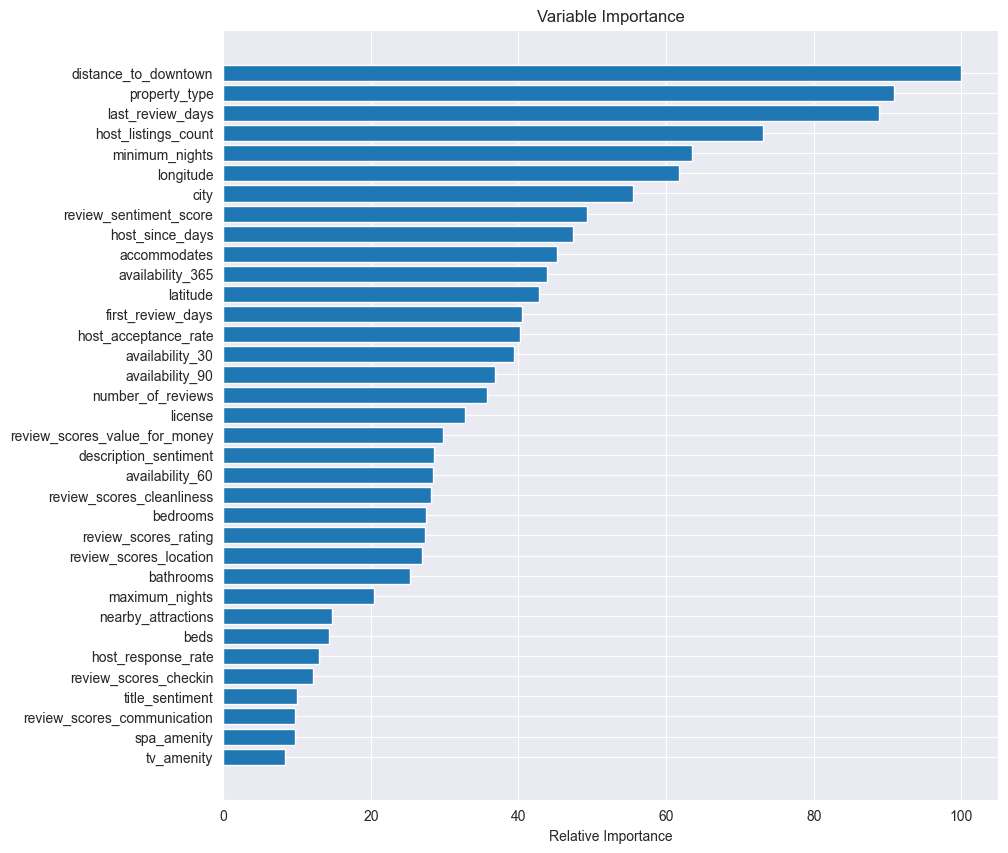

In [90]:
# Plot feature importance
top = 35
feature_importance = final_model_lgbm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize = (10,10))
plt.barh(pos[-top:], feature_importance[sorted_idx][-top:], align='center')
plt.yticks(pos[-top:], X_train.columns[sorted_idx][-top:])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

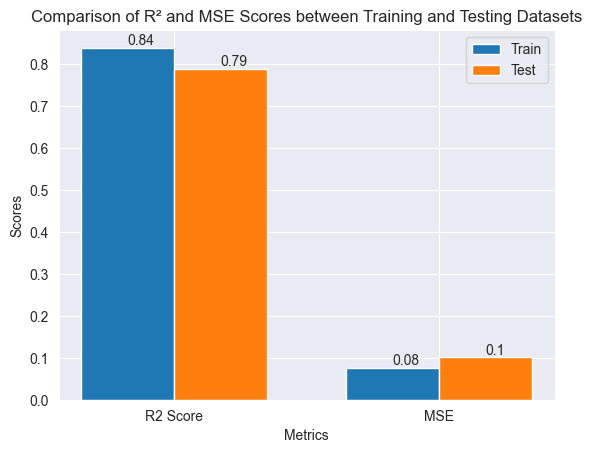

In [91]:
# Data for visualization
metrics = ['R2 Score', 'MSE']
train_scores = [lgbmr2t, lgbmmset]
test_scores = [lgbmr2, lgbmmse]

# Setting up the bar width and positions
bar_width = 0.35
index = np.arange(len(metrics))

# Creating the plot
fig, ax = plt.subplots()
train_bar = ax.bar(index, train_scores, bar_width, label='Train')
test_bar = ax.bar(index + bar_width, test_scores, bar_width, label='Test')

# Adding labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of R² and MSE Scores between Training and Testing Datasets')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

# Adding the scores on top of the bars
for bar in train_bar + test_bar:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), va='bottom')

# Display the plot
plt.show()

## New model

In [92]:
# Load listing data to airbnb_df
cluster_df = airbnb_df[['id', 'title', 'property_type', 'room_type', 'latitude', 'longitude', 'accommodates', 'amenities', 'price']]

cluster_df = cluster_df.dropna(subset=['price'])

# Merge user input df into cluster_df using only the necessary features above, and without preprocessing

In [93]:
# Checking for null values in the dataset
cluster_df.isnull().sum().sort_values(ascending=False)

id               0
title            0
property_type    0
room_type        0
latitude         0
longitude        0
accommodates     0
amenities        0
price            0
dtype: int64

In [95]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from geopy.distance import great_circle

# Create a LabelEncoder instance
label_encoder_property_type = LabelEncoder()
label_encoder_room_type = LabelEncoder()

# Apply label encoding to 'property_type' and 'room_type'
cluster_df['property_type_encoded'] = label_encoder_property_type.fit_transform(cluster_df['property_type'])
cluster_df['room_type_encoded'] = label_encoder_room_type.fit_transform(cluster_df['room_type'])

# Feature Engineering
features = cluster_df[['accommodates', 'room_type_encoded', 'property_type_encoded']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

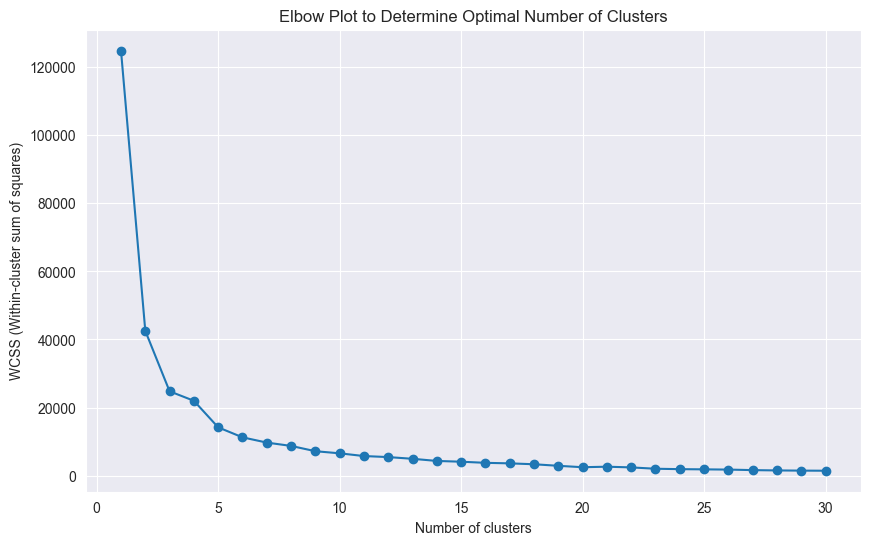

In [96]:
# Determine the ideal number of clusters using the elbow plot
wcss = []
max_clusters = 30
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within-cluster sum of squares)')
plt.title('Elbow Plot to Determine Optimal Number of Clusters')
plt.show()

In [97]:
# Clustering using KMeans
kmeans = KMeans(n_clusters=15, random_state=42)  # Adjust n_clusters as needed
cluster_df['cluster'] = kmeans.fit_predict(features_scaled)

In [98]:
# Print the resulting clusters
print(cluster_df['cluster'].value_counts())

cluster
1     8915
3     6853
6     6714
7     5639
14    4194
5     2567
10    2278
4     2000
13     698
0      538
12     313
2      304
8      287
11     215
9       57
Name: count, dtype: int64


In [99]:
# Example usage: find similar listings for a randomly selected target listing
target_listing_id = np.random.choice(cluster_df['id'])

# Find the cluster of the target listing
target_cluster = cluster_df[cluster_df['id'] == target_listing_id]['cluster'].values[0]

# Get the latitude and longitude of the target listing
target_location = cluster_df[cluster_df['id'] == target_listing_id][['latitude', 'longitude']].values[0]

# Filter the listings that fall into the same cluster
same_cluster_listings = cluster_df[cluster_df['cluster'] == target_cluster]

# Function to check if a listing is within a given radius
def is_within_radius(row, target_location, radius_km):
    listing_location = (row['latitude'], row['longitude'])
    return great_circle(listing_location, target_location).km <= radius_km

# Apply the distance function
same_cluster_listings['within_radius'] = same_cluster_listings.apply(is_within_radius, target_location=target_location, radius_km=2, axis=1)

# Filter listings that are within the 2km radius
within_radius_listings = same_cluster_listings[same_cluster_listings['within_radius']]

# Drop the 'within_radius' column as it's no longer needed
within_radius_listings = within_radius_listings.drop(columns=['within_radius'])

print(f'{within_radius_listings.shape[0]} similar listings found nearby.')

# Decode the label encoding for 'property_type' and 'room_type'
within_radius_listings['property_type'] = label_encoder_property_type.inverse_transform(
    within_radius_listings['property_type_encoded'])
within_radius_listings['room_type'] = label_encoder_room_type.inverse_transform(
    within_radius_listings['room_type_encoded'])

# Display specified columns
display_columns = ['title', 'property_type', 'room_type', 'accommodates', 'amenities', 'latitude', 'longitude', 'price']
result = within_radius_listings[display_columns]

# Display the result
result.head(5)

538 similar listings found nearby.


,title,property_type,room_type,accommodates,amenities,latitude,longitude,price
37748,A Real Gem in the Heart of Kits,Entire rental unit,Entire home/apt,4,"[""Hot water kettle"", ""Wine glasses"", ""Cleaning...",49.27190,-123.15043,141.0
37758,Trendy & Spacious 2 bd Gastown Loft,Entire loft,Entire home/apt,4,"[""Hot water kettle"", ""Toaster"", ""Wine glasses""...",49.28211,-123.10453,285.0
37765,Level | One Bedroom Suite | Downtown Vancouver,Entire serviced apartment,Entire home/apt,4,"[""Hot water kettle"", ""Toaster"", ""Private patio...",49.27741,-123.12292,260.0
37785,Private apartment-Yaletown Downtown,Entire rental unit,Entire home/apt,4,"[""Wifi"", ""Elevator"", ""Dryer"", ""Washer"", ""Pool""...",49.27744,-123.11524,459.0
37799,Luxury apartment Downtown Vancouver,Entire rental unit,Entire home/apt,4,"[""Wifi"", ""Elevator"", ""Dryer"", ""Washer"", ""Gym"",...",49.28361,-123.11536,316.0


### Model Interpretability using SHAP

In [101]:
import shap

def XAI_SHAP(model, data, graph, obs=0):
    """ Computes SHAP values and represents XAI graphs

    - Parameters:
        - model = Machine Learning model to interpret
        - data = Data used to make explanations
        - graph = Global or local interpretation
        - obs = Index of data instance to explain

    - Output:
        - XAI graphs and SHAP values
    """
    # Print JavaScript visualizations
    shap.initjs()

    # Create object to calculate SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer(data)
    
    if graph == 'global':
        # Global Interpretability (feature importance)
        shap.plots.bar(shap_values, max_display=20)
        
        # Global Interpretability (impact on target variable)
        shap.summary_plot(shap_values, data, max_display=20)
        
    else:
        # Local Interpretability (coefficients)
        shap.plots.bar(shap_values[obs], max_display=20)
        shap.plots.waterfall(shap_values[obs], max_display=20)

        # Local Interpretability (force plots)
        shap.plots.force(shap_values[obs])
    return shap_values

In [102]:
# Stack features and target
test = [X_test, y_test]

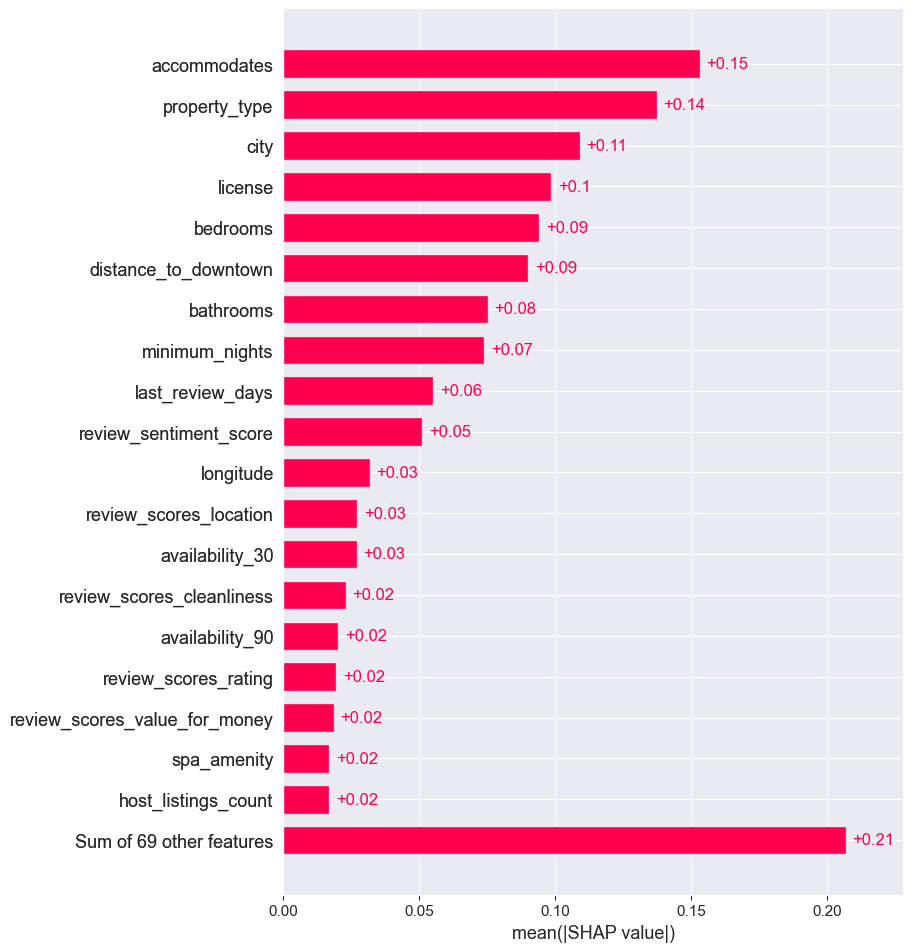

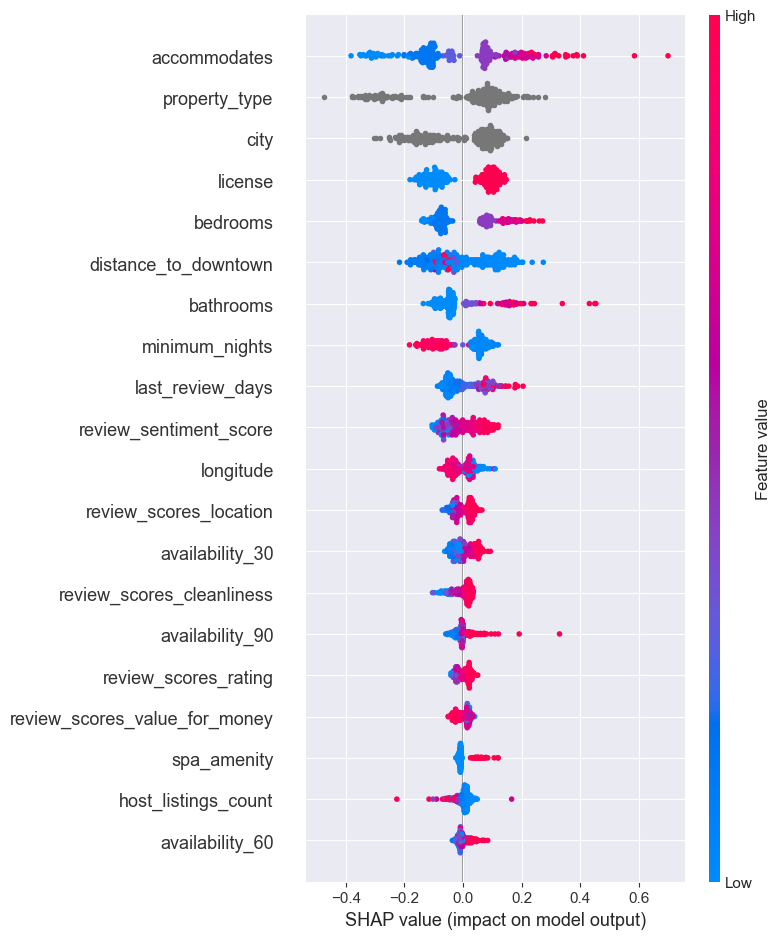

In [103]:
# SHAP values and plots for Global Interpretability
shap_values = XAI_SHAP(final_model_lgbm, test[0], 'global')

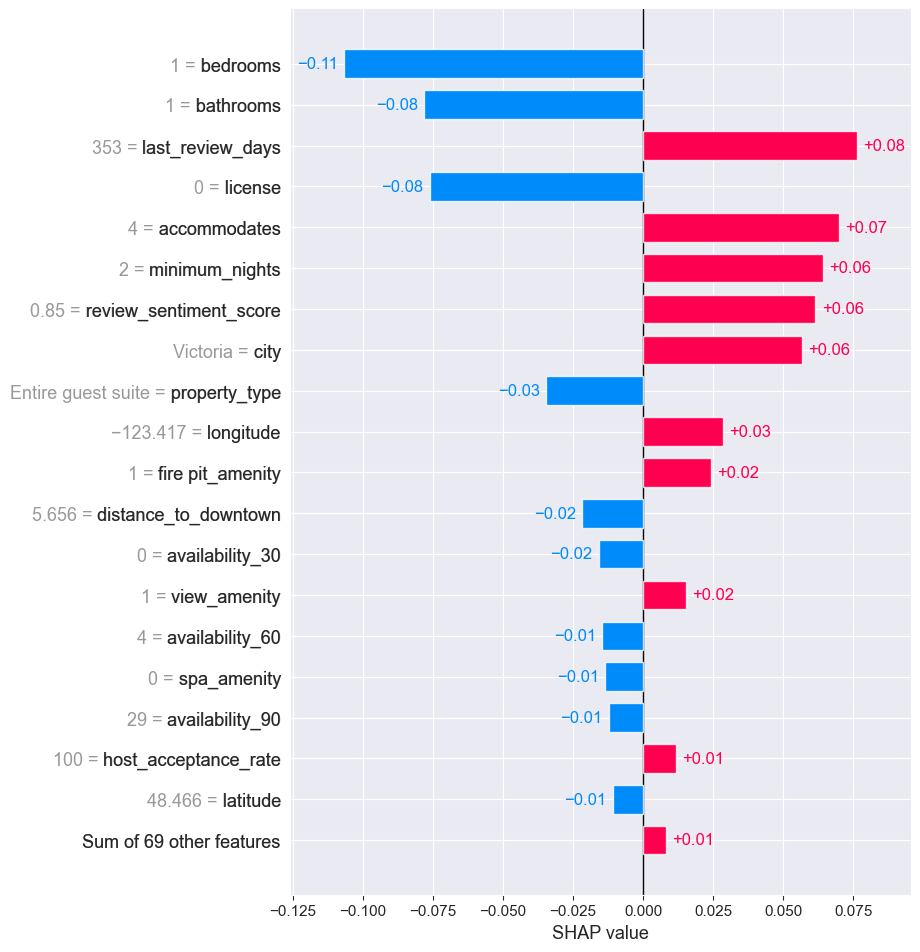

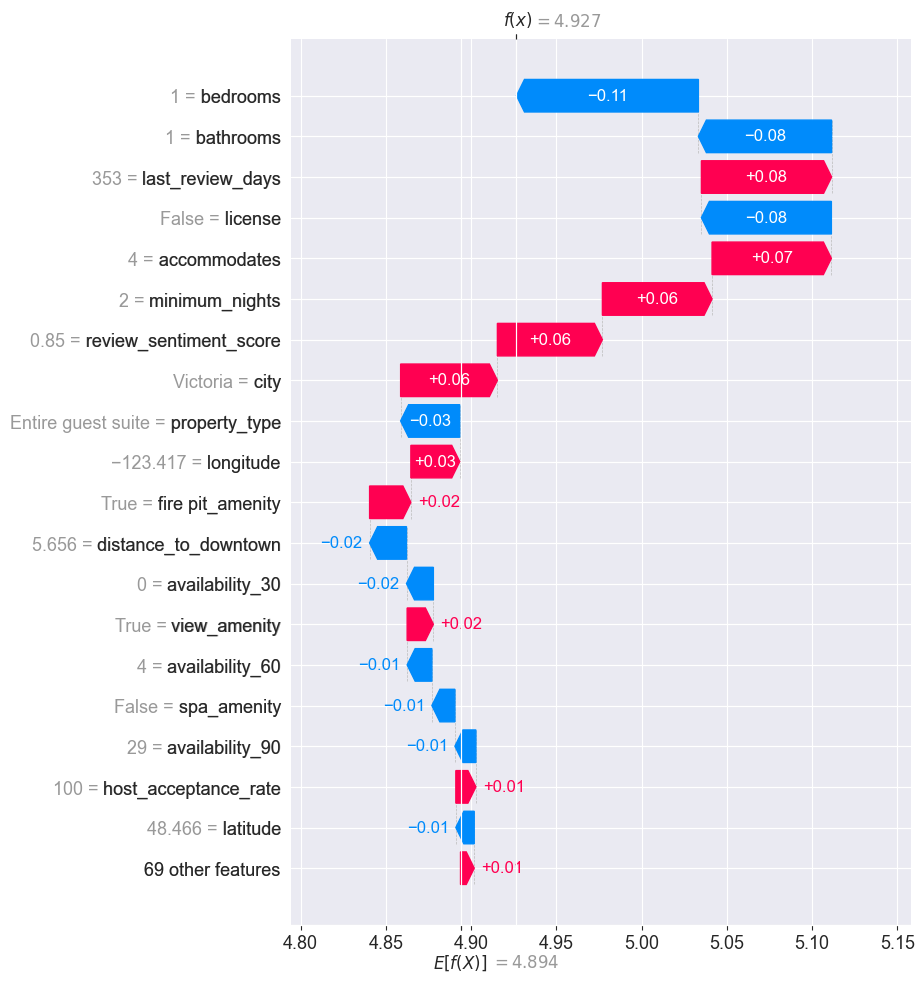

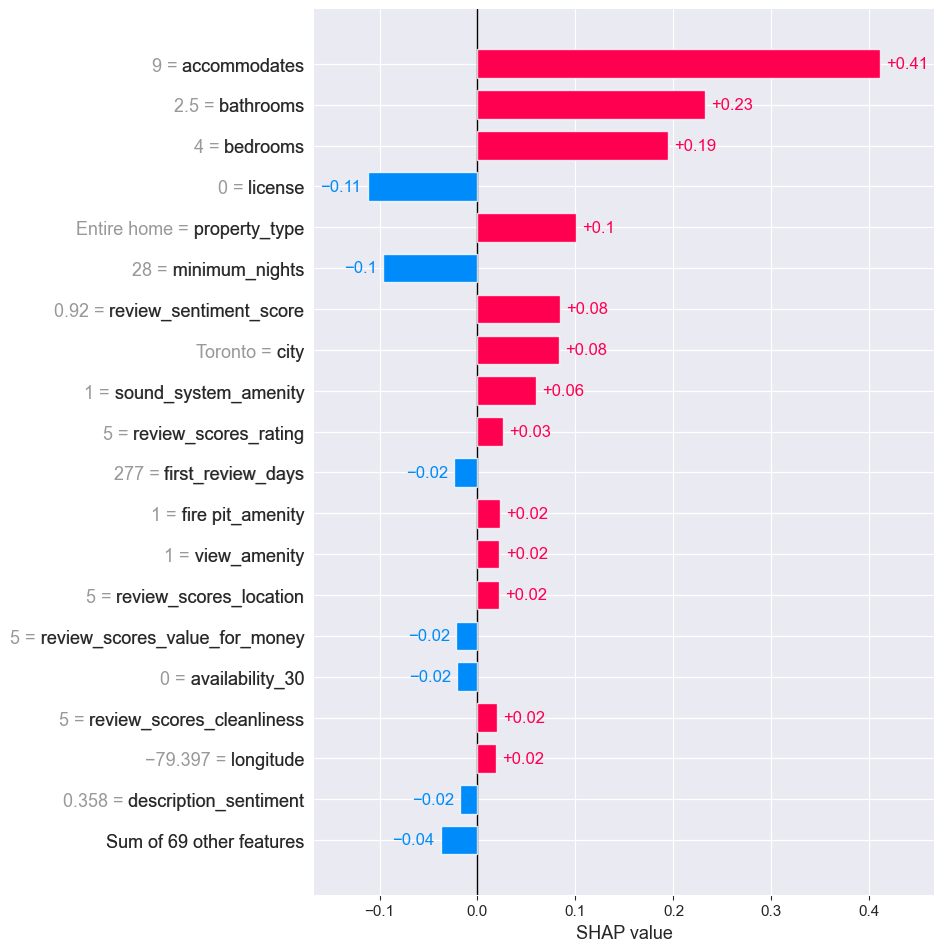

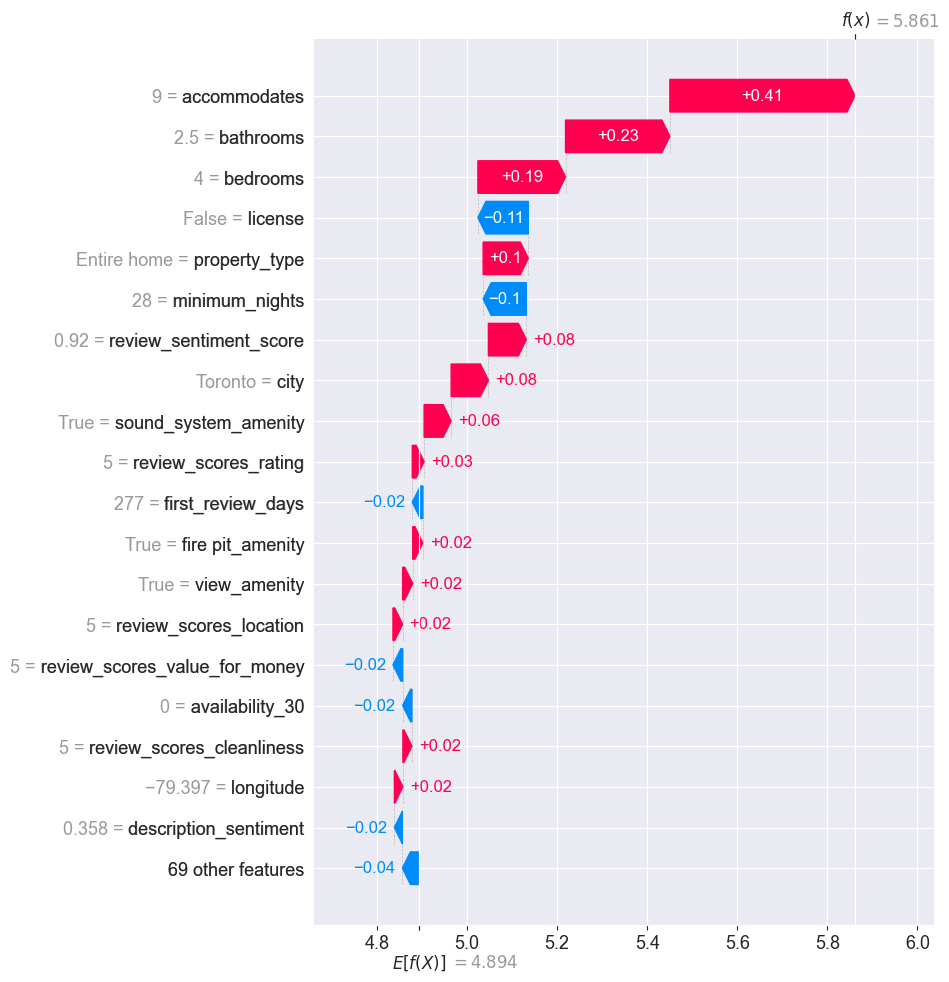

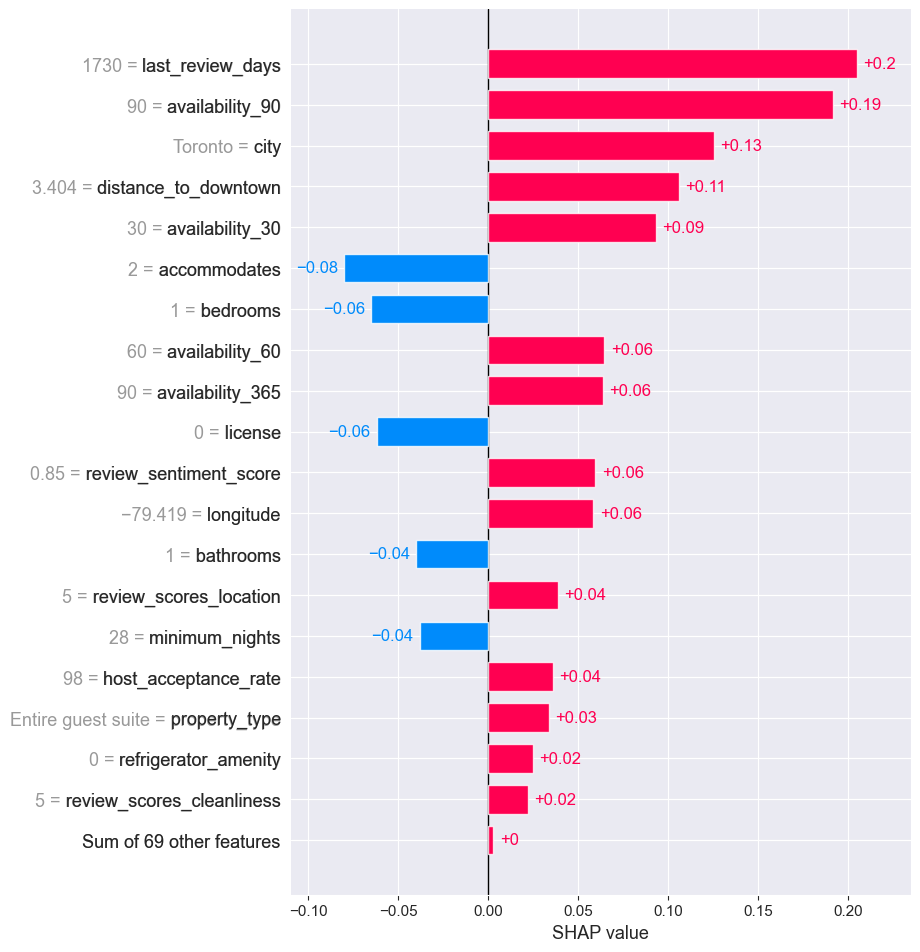

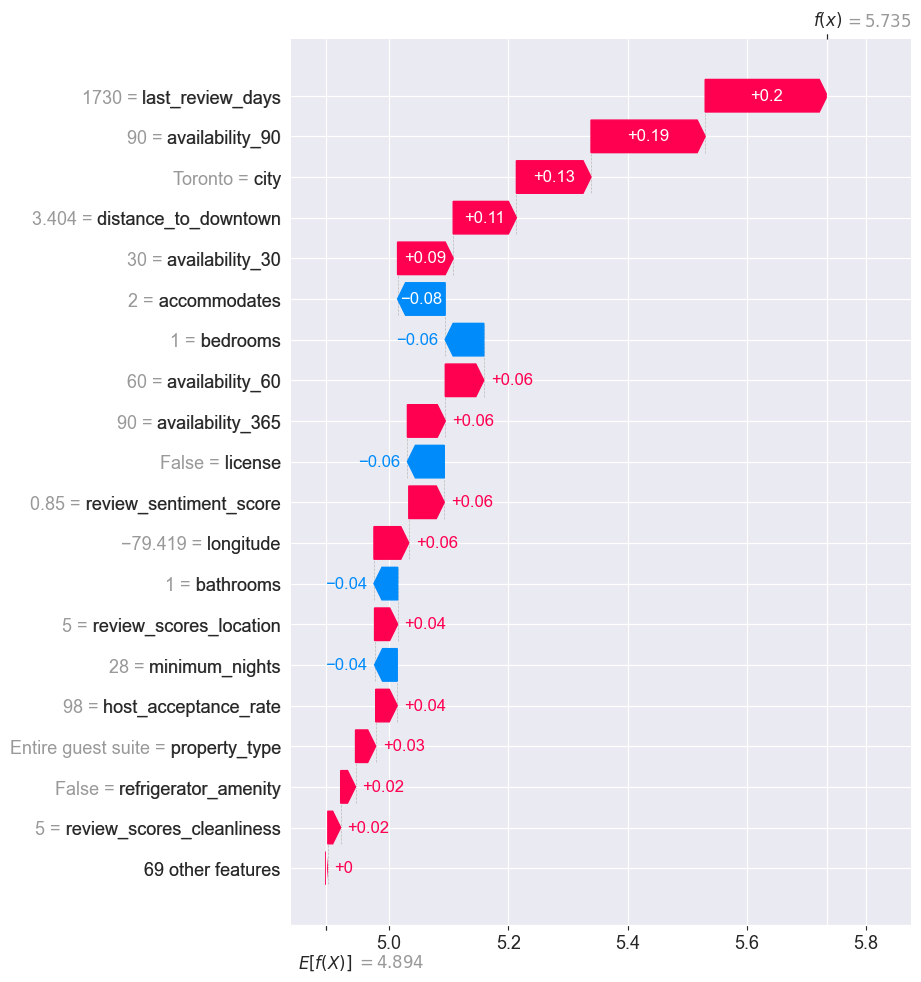

In [104]:
# SHAP values and plots for Local Interpretability
shap_values = XAI_SHAP(final_model_lgbm, test[0], 'local', 24)
shap_values = XAI_SHAP(final_model_lgbm, test[0], 'local', 165)
shap_values = XAI_SHAP(final_model_lgbm, test[0], 'local', 124)